# Visualizing Dense layer using ActivationMaximization

## Preparation

### Install libraries

At first, when you didn't yet installed `tf-keras-vis` in your environment such Google Colab, please run the cell below.

In [ ]:
!pip install --upgrade tf-keras-vis tensorflow matplotllib

### Load libraries

In [2]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('{} GPUs'.format(gpus))

0 GPUs


### Load tf.keras.Model

This tutorial use VGG16 model in tf.keras but if you want to use other tf.keras.Models, you can do so by modifing section below.

In [3]:
from tensorflow.keras.applications.vgg16 import VGG16 as Model

# Load model
model = Model(weights='imagenet', include_top=True)
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Visualizing a specific output category

### Define a function to modify the model

Define modifier to replace a softmax function of the last layer to a linear function.

In [4]:
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear

### Create ActivationMaximization Instnace

If `clone` argument is True(default), the `model` will be cloned, so the `model` instance will be NOT modified, but it takes a machine resources.

In [5]:
from tf_keras_vis.activation_maximization import ActivationMaximization

activation_maximization = ActivationMaximization(model,
                                                 model_modifier,
                                                 clone=False)

### Define Loss function

You MUST define Loss function that return arbitrary category value. Here, we try to visualize a category as defined No.20 (ouzel) of imagenet.

In [6]:
def loss(output):
    return output[:, 20]

Steps: 050	Losses: [[75.97147369384766]],	Regularizations: [('TotalVariation', 76.79798126220703), ('L2Norm', 0.02566402032971382)]
Steps: 100	Losses: [[110.76881408691406]],	Regularizations: [('TotalVariation', 84.4411849975586), ('L2Norm', 0.025611484423279762)]
Steps: 150	Losses: [[140.83351135253906]],	Regularizations: [('TotalVariation', 90.60466766357422), ('L2Norm', 0.02556171454489231)]
Steps: 200	Losses: [[191.7760467529297]],	Regularizations: [('TotalVariation', 117.30802917480469), ('L2Norm', 0.025499260053038597)]


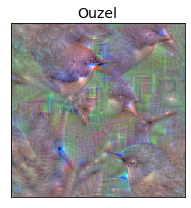

In [7]:
from tf_keras_vis.utils.callbacks import Print

activation = activation_maximization(loss,
                                     callbacks=[Print(interval=50)])
image = activation[0].astype(np.uint8)

subplot_args = { 'nrows': 1, 'ncols': 1, 'figsize': (3, 3),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
f, ax = plt.subplots(**subplot_args)
ax.imshow(image)
ax.set_title('Ouzel', fontsize=14)
plt.tight_layout()
plt.show()

## Visualizing specific output categories

Then, let's visualize multiple categories at once!

### Define Loss function

You MUST define Loss function that return arbitrary category values. Here, we try to visualize categories as defined No.1 (Goldfish), No.294 (Bear) and No.413 (Assault rifle) of imagenet.

In [8]:
image_titles = ['Goldfish', 'Bear', 'Assault rifle']

def loss(output):
    return (output[0, 1], output[1, 294], output[2, 413])

### Create SeedInput values

And then, you MUST prepare seed-input value. In default, when visualizing a conv filter, tf-keras-vis automatically generate seed-input for generating a image. When visualizing multiple conv filters, you MUST manually generate seed-input whose samples-dim is as many as the number of the filters you want to generate.

In [9]:
seed_input = tf.random.uniform((3, 224, 224, 3), 0, 255)

Here, we will visualize 3 images while `steps` option is to be 512 to get clear images.

Steps: 050	Losses: [[211.36558532714844, 100.59310913085938, 98.48896789550781]],	Regularizations: [('TotalVariation', 34.125789642333984), ('L2Norm', 0.014772474765777588)]
Steps: 100	Losses: [[344.4913024902344, 192.37498474121094, 181.83897399902344]],	Regularizations: [('TotalVariation', 41.1580696105957), ('L2Norm', 0.014685857109725475)]
Steps: 150	Losses: [[369.1233215332031, 227.34324645996094, 198.0052947998047]],	Regularizations: [('TotalVariation', 40.52096939086914), ('L2Norm', 0.014625495299696922)]
Steps: 200	Losses: [[443.32257080078125, 297.9285583496094, 256.9330139160156]],	Regularizations: [('TotalVariation', 42.921634674072266), ('L2Norm', 0.014552727341651917)]
Steps: 250	Losses: [[427.0479736328125, 304.0061950683594, 267.3083190917969]],	Regularizations: [('TotalVariation', 43.4376220703125), ('L2Norm', 0.014489997178316116)]
Steps: 300	Losses: [[482.5263366699219, 318.5843505859375, 292.9072570800781]],	Regularizations: [('TotalVariation', 47.364749908447266), (

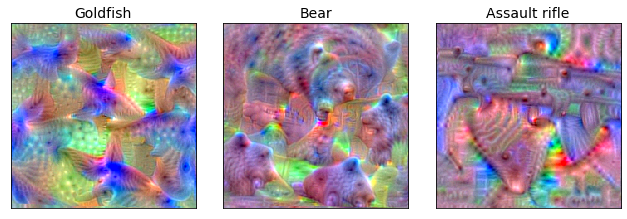

In [10]:
from tf_keras_vis.utils.callbacks import GifGenerator


# Define seed inputs whose shape is (samples, height, width, channels).

# Do 500 iterations and Generate an optimizing animation
activations = activation_maximization(loss,
                                      seed_input=seed_input,
                                      steps=512,
                                      callbacks=[ Print(interval=50)])
images = [activation.astype(np.uint8) for activation in activations]

# Render
subplot_args = { 'nrows': 1, 'ncols': 3, 'figsize': (9, 3),
                 'subplot_kw': {'xticks': [], 'yticks': []} }
f, ax = plt.subplots(**subplot_args)
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=14)
    ax[i].imshow(images[i])
plt.tight_layout()
plt.savefig('images/visualize-dense-layer')
plt.show()